# 3.1 线性回归
回归是能为一个或多个自变量与因变量之间关系建模的一类方法。

## 3.1.1 线性回归的基本元素
首先基于几个简单的假设：x和y之间的关系是线性的，y可以表示成x中元素的加权和，观测值通常有噪声；

其次，假设噪声都比较正常，遵循某种分布，比如遵循正态分布。

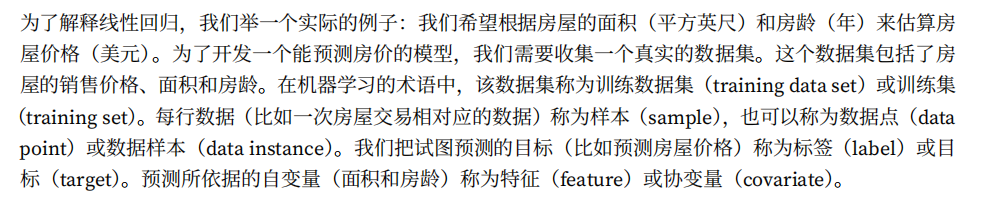

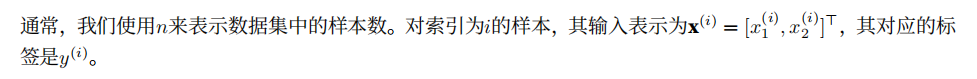

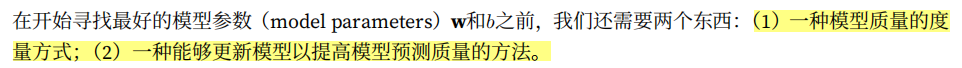

### 损失函数
用来量化目标的实际值与预测值之间的差距

通常选择非负数作为损失，且数值越小表示损失越小，完美预测时的损失为0.回归问题最常用的损失函数是平方误差函数：
$$
    l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat y ^{(i)} - y^{(i)}\right)^2
$$

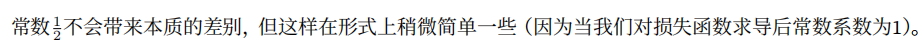}

为了度量模型在整个数据集上的质量，我们需要计算在训练集 $n$ 个样本上的损失均值(等价于求和)。
$$
L(\mathbf{w}, b) = \frac{1}{n} \sum_{i=1}^{n} l^{(i)}(\mathbf{w}, b) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{2} \left(\mathbf{w}^{T} x^{(i)} + b - y^{(i)}\right)^2  
$$
找到一组参数$(w^{*}, b^{*})$，这组参数能最小化在所有训练样本上的总损失。如下式:
$$
(w^{*}, b^{*}) = \arg\min_{w,b} L(w,b)
$$

### 随机梯度下降
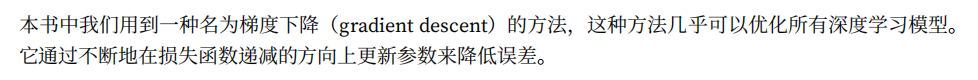

梯度下降最简单的方法是计算损失函数（数据集中所有样本的损失均值）关于模型参数的导数（就是模型参数的梯度），但是非常慢。所以，通常在每次需要计算更新的时候随机抽取一小批样本，这种变体叫做小批量随机梯度下降。

在每次迭代中，首先你随机抽取一个小批量 $B$, 它是由固定数量的训练样本组成的。然后，我们计算小批量的平均损失关于模型参数的梯度。最后，我们将梯度乘以一个预先确定的正数 $\eta$, 并从当前参数的值中减掉。

数学公式如下：
$$
(w, b) \leftarrow (w, b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(w,b)} l^{(i)}(w, b). 
$$

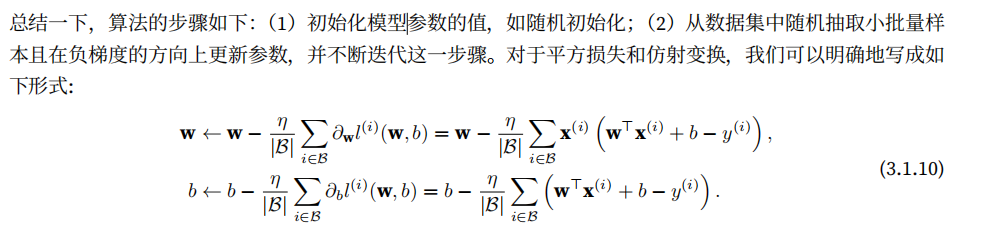

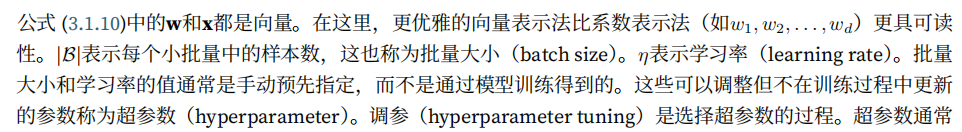

## 矢量化加速

在训练模型时，为了能够同时处理整个小批量的样本，我们对计算进行矢量化，从而利用线性代数库

In [1]:
%matplotlib inline
import math
import time
from mxnet import np
from d2l import mxnet as d2l

为了显示矢量化的重要性，考虑两种向量相加的方法。此向量是全为1的10000维向量。

一种是python的for循环遍历向量

另一种是依赖 $+$ 的运用

In [2]:
n = 10000
a = np.ones([n])
b = np.ones([n])

由于频繁进行时的预测和对比，所以定义一个计时器：

In [3]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        '''启动计时器'''
        self.tik = time.time()
    
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()
    

下面进行测试

首先，使用for循环吗，每次执行一位的加法。

In [4]:
c = np.zeros([n])

timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'1.60313 sec'

使用$+$来计算

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00024 sec'

# 正态分布与平方损失

通过对噪声分布的假设来解读平方损失目标函数。


正态分布概率密度函数如下：
$$
p(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{1}{2\sigma^2}(x - \mu)^2 \right)
$$

定义一个函数计算正态分布

In [7]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 /sigma**2 * (x - mu)**2)

可视化正态分布

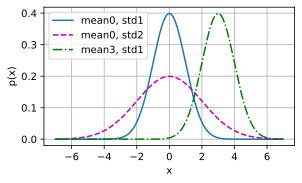

In [8]:
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x.asnumpy(), [normal(x, mu, sigma).asnumpy() for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean{mu}, std{sigma}' for mu, sigma in params])

分析：

增大均值，向右偏移

增大方差，增大分散分布，降低峰值

使用均方误差损失函数进行线性回归的原因：

假设观测中包含噪声，其中噪声服从标准正态分布。噪声正态分布如下式：
$$
y = \mathbf{w}^{T} \mathbf{x} + b + \epsilon
$$
可以写出通过给定的 $\mathbf{x}$ 观测到特定 $y$ 的似然函数(likelihood):
$$
P(y | \mathbf{x}) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{1}{2\sigma^2}(y - \mathbf{w}^{T} \mathbf{x} - b)^2 \right)
$$

最大这个似然估计，参数 $\mathbf{w}$ 和 $b$ 的最优值是使整个数据集的似然最大的值：
$$
P(\mathbf{y} | \mathbf{X}) = \prod_{i=1}^{n} p(y^{(i)} | x^{(i)}).
$$

通过最大化似然对数简化。
$$
- \log P(\mathbf{y} | \mathbf{X}) = \sum_{i=1}^{n} \frac{1}{2} \log(2\pi\sigma^2) + \frac{1}{2\sigma^2} \left( y^{(i)} - w^\top x^{(i)} - b \right)^2 .
$$

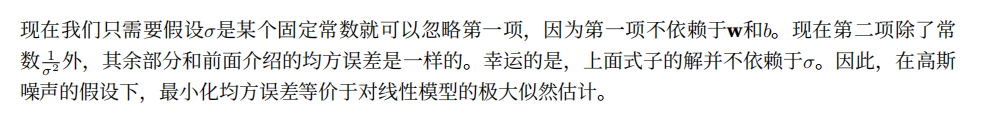

## 3.1.4 从线性回归到深度网络

用 “层” 符号来重写这个模型。

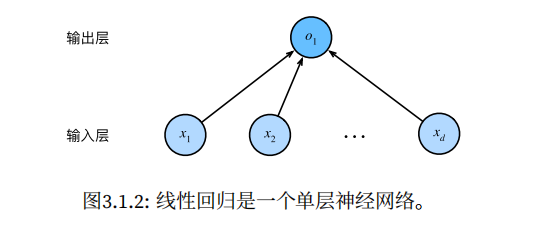

注意，该图只显示连接模式，即只显示每个输入如何连接到输出，隐去了权重和偏置的值

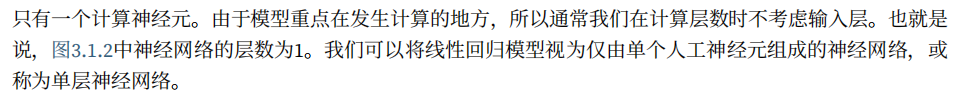

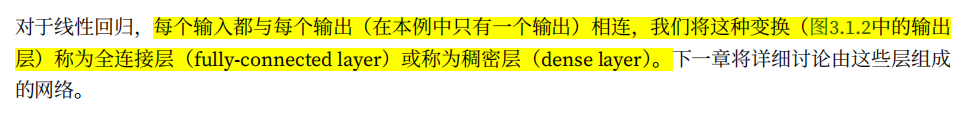


